Cell 1: Import Library and Module

In [1]:
import sys
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

from AES_CTR.AES_Lib import AES_Software
from ML_KEM import ML_KEM

print("Libraries imported successfully!")

Libraries imported successfully!


Cell 2: Camera Settings (Input)

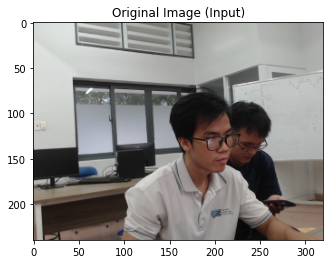

Image Shape: (240, 320, 3)
Data Type: uint8


In [2]:
# Khởi động Camera (trên Kria thường là device 0 cho USB Cam)
cap = cv2.VideoCapture(1)

# Capture a frame
ret, frame = cap.read()
if ret:
    # Resize nhỏ lại để demo chạy cho nhanh (ví dụ 320x240)
    frame = cv2.resize(frame, (320, 240))
    # Convert sang RGB để hiển thị đúng màu trên matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    plt.imshow(frame_rgb)
    plt.title("Original Image (Input)")
    plt.show()
    
    print(f"Image Shape: {frame_rgb.shape}")
    print(f"Data Type: {frame_rgb.dtype}")
else:
    print("Error: Could not read from camera.")
    cap.release()

Cell 3: Thực hiện trao đổi khóa Kyber (Key Exchange)
Đây là bước gen "secret share key" cho AESAES

In [3]:
print("--- START KYBER KEY EXCHANGE ---")
t0 = time.perf_counter()

# 1. Alice (Server/Recipient) sinh cặp khóa
pk, sk = ML_KEM.KeyGen()
print(f"1. KeyGen Done. PK Size: {len(pk)} bytes")

# 2. Bob (Client/Sender/Camera Node) đóng gói khóa chung (Encaps)
# Bob dùng Public Key của Alice để tạo ra Shared Secret
shared_secret_bob, ciphertext = ML_KEM.Encaps(pk)
print(f"2. Encaps Done. Ciphertext Size: {len(ciphertext)} bytes")

# 3. Alice giải mã (Decaps) để lấy khóa chung
shared_secret_alice = ML_KEM.Decaps(sk, ciphertext)
print(f"3. Decaps Done.")

t1 = time.perf_counter()
print(f"--- KYBER TIME: {(t1-t0)*1000:.2f} ms ---")

# Kiểm tra tính toàn vẹn
assert shared_secret_bob == shared_secret_alice
print("SUCCESS: Shared secrets match!")
print(f"Shared Key (Hex): {shared_secret_bob.hex()}")

--- START KYBER KEY EXCHANGE ---
1. KeyGen Done. PK Size: 800 bytes
2. Encaps Done. Ciphertext Size: 768 bytes
3. Decaps Done.
--- KYBER TIME: 2227.14 ms ---
SUCCESS: Shared secrets match!
Shared Key (Hex): 746c4b6fc76b4dbf6f5379000ceef844ee517010c89fd4e11caf2d20f3736aee


Cell 4: Mã hóa ảnh bằng AES (Dùng khóa Kyber)
Connect output của Kyber vào input của AESAES

--- START AES ENCRYPTION ---
--- ENCRYPTION TIME: 38.22 ms ---
Encrypted Data Size: 230400 bytes


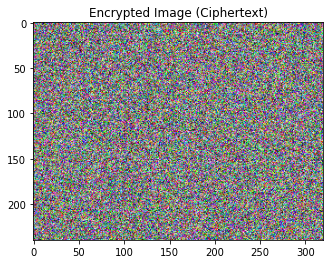

In [4]:
print("--- START AES ENCRYPTION ---")

# Sử dụng shared_secret từ Kyber làm khóa cho AES
aes_key = shared_secret_bob 

# Khởi tạo bộ mã hóa AES
my_aes = AES_Software(aes_key)

t2 = time.perf_counter()

# Thực hiện mã hóa ảnh
encrypted_data = my_aes.encrypt_image(frame_rgb)

t3 = time.perf_counter()
print(f"--- ENCRYPTION TIME: {(t3-t2)*1000:.2f} ms ---")
print(f"Encrypted Data Size: {len(encrypted_data)} bytes")

# Hiển thị dữ liệu mã hóa (Sẽ trông như nhiễu)
# Chúng ta reshape tạm để hiển thị dạng ảnh noise
encrypted_view = np.frombuffer(encrypted_data, dtype=np.uint8).reshape(frame_rgb.shape)
plt.imshow(encrypted_view)
plt.title("Encrypted Image (Ciphertext)")
plt.show()

Cell 5: Giải mã và Kiểm tra

--- START AES DECRYPTION ---
--- DECRYPTION TIME: 9.26 ms ---


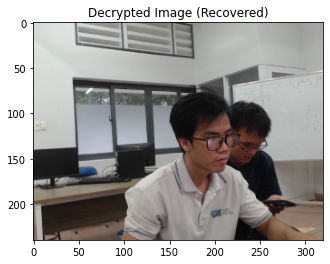

✅ SYSTEM VERIFIED: Decrypted image matches original exactly.


In [5]:
print("--- START AES DECRYPTION ---")

t4 = time.perf_counter()

# Thực hiện giải mã
decrypted_img = my_aes.decrypt_to_image(encrypted_data, frame_rgb.shape, frame_rgb.dtype)

t5 = time.perf_counter()
print(f"--- DECRYPTION TIME: {(t5-t4)*1000:.2f} ms ---")

# Hiển thị ảnh sau giải mã
plt.imshow(decrypted_img)
plt.title("Decrypted Image (Recovered)")
plt.show()

# Kiểm tra dữ liệu gốc và dữ liệu giải mã có giống hệt nhau không
if np.array_equal(frame_rgb, decrypted_img):
    print("✅ SYSTEM VERIFIED: Decrypted image matches original exactly.")
else:
    print("❌ ERROR: Data mismatch.")